In [35]:
%pip install -q matplotlib scikit-learn seaborn textblob inflect pycountry spacy


Note: you may need to restart the kernel to use updated packages.


In [168]:

# Define a sample string
string = '  Venezuela   '


def clean_country(string):
    # Remove the word "ISO" from the string
    string = string.replace("ISO", "")

# Loop through all countries in pycountry
    for country in pycountry.countries:
        # Check if the country name, 2-letter code, or 3-letter code is in the string
        clean_country=country.name.lower() in string.lower()
        
        # Loop through all countries in pycountry
    for country in pycountry.countries.name:
        # Check if the country name is in the string
        if country.lower() in string.lower():
            # If a match is found, return the country name
            return country.name
        
        if clean_country != False: 
            return country.name
            break
        
        else:
            clean_country=country.alpha_3 in string 
            if clean_country != False:
                return country.name
                break
            else:
                clean_country= country.alpha_2 in string
                if clean_country != False:
                    return country.name
                    break
                
    if 'GB' in string:
        return "United Kingdom"
    if 'Syria' in string:
        return "Syrian Arab Republic"
    if 'Venezuela' in string or 'VZL' in string or 'VZ' in string:
        return "Venezuela, Bolivarian Republic of" 
    # If no country is found return "Country Not Found"
    return 'Country Not Found'            
            
            
        # If a match is found, print the country name
clean_country(string)        

AttributeError: 'ExistingCountries' object has no attribute 'name'

In [32]:

import pandas as pd
import numpy as np
import json
import os
import csv
import time
import re
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import inflect
import pycountry 


In [289]:
testing_df2 = pd.read_csv(r'C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Country\result_df_country_e2.csv')


In [291]:
#Parse text functions
#################################################  
# Extracting the Crisis Type label from the text#
#################################################  
def parse_label_crisistype(text):
  colon_index = text.lower().find('"crisis": ')
  if colon_index != -1:
    substring = text[ colon_index +len('"Crisis": '):]
    # Find the index of the closing double quote or closing quote
    if substring.startswith('"'):
      end_index = substring.find('"',1)
      if end_index != -1:
        return substring[1:end_index]
      else:
        return "missing 2nd apostrophe"
    else:
      end_index = substring.find("\n")
      if end_index != -1:
        return substring[:end_index]
      else:
        return "missing '\n'"
  else:
    return "No 'Crisis' key in data"

#######################################################    
# Extracting the Information Type label from the text #
#######################################################   
InfoTypeLabels =  [ "Caution and advice for residents", "Written by Affected individuals", "Infrastructure and utilities damage", "Soliciting Donations or volunteering to help", "expressing Sympathy and support for affected", "other useful information", "Not applicable"]

def parse_label_infotype(text):
    colon_index = text.lower().find("Label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in InfoTypeLabels:
                if label.lower() in substring.lower():
                    return label
    for label in InfoTypeLabels:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    return "Error"

  ##############################################                                            
  # Extracting the Country label from the text #
  ##############################################                                          
def parse_label_country(text):
    # Remove the word "ISO" from the string
    text = text.replace("ISO", "")

# Loop through all countries in pycountry
    for country in pycountry.countries:
        # Check if the country name is in the string
        if country.name.lower() in text.lower():
            # If a match is found, return the country name
            return country.name
            break
        
# Loop through all countries in alpha 3 pycountry
    for country in pycountry.countries:
        if country.alpha_3 in text:
            return country.name
            break
    
# Loop through all countries in alpha 2 pycountry
    for country in pycountry.countries:
        if country.alpha_2 in text:
            return country.name
            break
# Check if 'UK' is in the string
    if 'UK' in text:
        return "United Kingdom"
        
# Check if 'Syria' is in the string
    if 'Syria' in text:
        return "Syrian Arab Republic"
        
# Check if 'Russia' is in the string
    if 'Russia' in text:
        return "Russian Federation"
        
# Check if 'Scotland' is in the string
    if 'Scotland' in text:
        return "United Kingdom"
        
    if 'Venezuela' in text or 'VZL' in text or 'VZ' in text:
        return "Venezuela, Bolivarian Republic of" 
           
# Check if 'SP' is in the string
    if 'SP' in text or 'España' in text:
        return "Spain"
        
#If no country is found return "Country Not Found"
    return 'Country Not Found' 


In [292]:

# Turn plural into singular of the parsed labels using inflect and change to sentence case
def singular_label(df, parsed_column):
  # Create an instance of the inflect engine
  engine = inflect.engine()

  # Convert a plural word to a singular word
  df[parsed_column] = df[parsed_column].apply(lambda x: engine.singular_noun(x) if engine.singular_noun(x) else x)

  # Change to sentence case
  df[parsed_column] = df[parsed_column].str.capitalize()


# Rename parsed labels so they match original labels in the dataset
def rename_label(df, parsed_column, label_column):
    # Define a dictionary to map old labels to new labels
    label_map = {
        'Wildfires': 'Wildfire',
        'Bushfires': 'Wildfire',
        'Bushfire': 'Wildfire',
        'Na': 'Not labeled',
        '[Na]': 'Not labeled',
        'fire': 'Wildfire'
    }
    # Define a dictionary to map old labels to new labels
    label_map_actual = {
        'Philipinnes': 'Philippines',
        'Phillipines': 'Philippines',
        'UK': 'United Kingdom',
        'Venezuela': 'Venezuela, Bolivarian Republic of',
        'Russia': 'Russian Federation',
        'US' : 'United States',
    }
    # Rename the parsed_column using the label_map dictionary
    df[parsed_column] = df[parsed_column].replace(label_map)

    # Relabel the "Not labeled" Information Type entries as "Not labeled" for the Crisis Type
    df.loc[df["InformationType"] == "Not labeled", label_column] = "Not labeled"

    # Rename the label_column using the label_map dictionary
    df[label_column] = df[label_column].replace(label_map_actual)


# # Rename predicted entries that are not in the top 8 as not labeled
# #Count the values in the "Label" column
# label_counts = testing_df2['parsed_pred_crisis_type_13'].value_counts()

# # Define the threshold for the top labels
# threshold = 8

# # Get the labels that meet the threshold
# top_labels = label_counts.index[:threshold]

# # Replace the labels that do not meet the threshold with "Not labeled"
# testing_df2['parsed_pred_crisis_type_13'] = testing_df2['parsed_pred_crisis_type_13'].replace(to_replace={value: 'Not labeled' for value in testing_df2['parsed_pred_crisis_type_13'].unique() if value not in top_labels})



In [306]:
# Rename predicted entries that are not in the top 8 as not labeled
def top_labels(df, parsed_column):
    #Count the values in the "Label" column
    label_counts = df[parsed_column].value_counts()

    # Define the threshold for the top labels
    threshold = 20

    # Get the labels that meet the threshold
    top_labels = label_counts.index[:threshold]

    # Replace the labels that do not meet the threshold with "Other"
    df[parsed_column] = df[parsed_column].replace(to_replace={value: 'Other' for value in df[parsed_column].unique() if value not in top_labels})
 

In [294]:
#Apply Parse function and get answers in sentence case
testing_df2['parsed_pred_country'] = testing_df2['country_pred'].apply(parse_label_country)

In [ ]:
# Apply singular and sentence case to parsed labels
# singular_label(testing_df2, 'parsed_pred_crisis_type_13')

In [ ]:
# Rename parsed labels so they match original labels in the dataset
# rename_label(testing_df2, 'parsed_pred_crisis_type_13', 'type')

In [295]:
# show the first 20 rows of the dataframe with the columns "TweetText","country","InformationType","country_pred","parsed_pred_country"
# country_df=testing_df2[["TweetText","country","InformationType","country_pred","parsed_pred_country"]].head(-25)



In [319]:
country_df=testing_df2[["TweetText","country","InformationType","country_pred","parsed_pred_country"]]
# save df as csv testing_df2
testing_df2.to_csv(r'C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Country\result_df_country.csv', index = None, header=True)


In [307]:
top_labels(testing_df2, 'parsed_pred_country')
testing_df2[["TweetText","country","InformationType","country_pred","parsed_pred_country"]]


,TweetText,country,InformationType,country_pred,parsed_pred_country
0,"RT @CBCAlerts: Canmore, Alta. declares state o...",Canada,Affected individuals,Canada,Canada
1,RT @GlobalCalgary: If you are in #Canmore and ...,Canada,Caution and advice,Canada,Canada
2,RT @metrocalgary: UPDATE: Latest from the @cit...,Canada,Caution and advice,Canada,Canada
3,RT @GlobalCalgary: GALLERY: Incredible photos ...,Canada,Not applicable,Canada,Canada
4,RT @nenshi: Major risk of flooding in Calgary....,Canada,Caution and advice,Canada,Canada
...,...,...,...,...,...
25964,RT @ElisabettaCFans: @LidasezOlbia Nell'appell...,Italy,Sympathy and support,Italy (IT),Italy
25965,"RT @MeteoWeb_eu: Alluvione Sardegna, alto risc...",Italy,Caution and advice,Sardinia (Italy),Italy
25966,RT @nicola_pinna: A #Olbia adesso c'è bisogno ...,Italy,Donations and volunteering,Sardinia (IT),Italy
25967,"Alluvione Sardegna, alto rischio epidemie per ...",Italy,Caution and advice,Italy (IT),Italy


In [ ]:
# show the first 20 rows of the dataframe with the columns "TweetText","type","InformationType","pred_crisis_type_13","parsed_pred_crisis_type_13"
# testing_df2[["TweetText","type","InformationType","pred_crisis_type_13","parsed_pred_crisis_type_13"]].head(20)



In [308]:
# Rename predicted entries that are not in the top 8 as not labeled
#Count the values in the "Label" column
label_counts = testing_df2['parsed_pred_country'].value_counts()
print(label_counts)

parsed_pred_country
Country Not Found                    8326
Philippines                          3483
United States                        2136
Canada                               1726
Italy                                1547
Australia                            1363
Bangladesh                           1056
Brazil                                877
Singapore                             806
Spain                                 790
Guatemala                             761
Costa Rica                            727
Venezuela, Bolivarian Republic of     629
Russian Federation                    597
Other                                 544
United Kingdom                        230
Mexico                                156
Colombia                               83
Chile                                  80
Ecuador                                77
Name: count, dtype: int64


In [309]:
rename_label(testing_df2, 'parsed_pred_country', 'country')

In [ ]:
# save df as csv testing_df2
testing_df2.to_csv(r'C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Country\result_df_country_e2_parsed2.csv', index = None, header=True)


In [ ]:
# Create a confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

def plt_confusion_matrix ( actual_values, predicted_values):
  #compute the confusion matrix.
  cm = confusion_matrix(actual_values, predicted_values)
  cm = cm[np.any(cm, axis=1)]
  print(cm)


  #Create the unique labels
  # labels = unique_labels(actual_values, predicted_values)
  ylabel=np.unique(actual_values)
  xlabel=np.unique(predicted_values) 

  # Create a mask that selects the diagonal elements
  # mask = np.eye(len(labels), dtype=bool)

  # Create a color map with blue off-diagonal elements and green diagonal elements
  cmap = sns.diverging_palette(220, 20, as_cmap=True)
  cmap.set_bad("green")


  #Plot the confusion matrix.
  fig = plt.figure()
  sns.heatmap(cm,
              annot=True,
              fmt='g',
              xticklabels=xlabel,
              yticklabels=ylabel,
              cbar=False)
  # sns.heatmap(cm,
  #             # annot=False,
  #             # fmt='g',
  #             xticklabels=xlabel,
  #             yticklabels=ylabel,
  #             mask=mask,
  #             cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white' )

  plt.ylabel('Actual',fontsize=13)
  plt.xlabel('Prediction',fontsize=13)
  plt.title('Confusion Matrix',fontsize=17)
  plt.show()
  plt.clf()


  # Calculate accuracy
  accuracy = accuracy_score(actual_values, predicted_values)

  # Calculate precision
  precision = precision_score(actual_values, predicted_values, average='weighted')

  # Calculate recall
  recall = recall_score(actual_values, predicted_values, average='weighted')

  # Calculate F1-score
  f1 = f1_score(actual_values, predicted_values, average='weighted')

  
# Number of rows in dataframe

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f1}')
  print('Unique Predict Labels: ',list(np.unique(predicted_values)))
  print('Unique Actual Labels: ',list(np.unique(actual_values)))
  print('Number of rows: ',len(testing_df2.index))
  print(predicted_values.value_counts())

In [315]:
# Create a confusion matrix for country
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

def plt_confusion_matrix ( actual_values, predicted_values):
  #Create the unique labels
  labels = unique_labels(actual_values, predicted_values)
  indices = np.where((labels == 'Not Labeled') | (labels == 'Country Not Found') | (labels == 'Other'))
  labels = np.delete(labels, indices)
  labels = np.append(labels, ['Country Not Found', 'Not Labeled', 'Other'])
  
  #compute the confusion matrix.
  cm = confusion_matrix(actual_values, predicted_values,labels=labels)
 
  print(cm)



  # #Create a mask that selects the diagonal elements
  mask = np.eye(len(labels), dtype=bool)

  # Create a color map with blue off-diagonal elements and green diagonal elements
  cmap = sns.diverging_palette(220, 20, as_cmap=True)
  cmap.set_bad("green")
  
  #Plot the confusion matrix.
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.heatmap(cm,
              annot=True,
              fmt='g',
              xticklabels=labels,
              yticklabels=labels,
              cbar=False,
              annot_kws={"fontsize":7})
  sns.heatmap(cm,
              # annot=False,
              # fmt='g',
              xticklabels=labels,
              yticklabels=labels,
              mask=mask,
              cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white')

  plt.ylabel('Actual',fontsize=13)
  plt.xlabel('Prediction',fontsize=13)
  plt.title('Confusion Matrix',fontsize=17)
  plt.show()
  plt.clf()


  # Calculate accuracy
  accuracy = accuracy_score(actual_values, predicted_values)

  # Calculate precision
  precision = precision_score(actual_values, predicted_values, average='weighted')

  # Calculate recall
  recall = recall_score(actual_values, predicted_values, average='weighted')

  # Calculate F1-score
  f1 = f1_score(actual_values, predicted_values, average='weighted')

  
# Number of rows in dataframe

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f1}')
  print('Unique Predict Labels: ',list(np.unique(predicted_values)))
  print('Unique Actual Labels: ',list(np.unique(actual_values)))
  print('Number of rows: ',len(testing_df2.index))
  print(predicted_values.value_counts())

[[1101    0    1    0    0    0    0    0    0    0    0    0    0    1
     0    0    0    0  657    0    7]
 [   0  813    0    3    0    0    0    0    0    0    0    0    0    0
     0    2    2    0   25    0   44]
 [   0    0  837    0    0    0    0    0    0    0    0    0    0    0
     0    0    1    0   71    0    8]
 [  63    0    1 1562    0    0    0    0    0    0    0    0    0    0
     1    0    4    0  166    0    5]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2    0    0    0   35    3  655    1    1    0   12    0    0    0
     0    0    4    0  131    0   20]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0   19    0    1    0  719    0   79    0    0    0
     0    0    1    3   76    0   21]
 [   0    

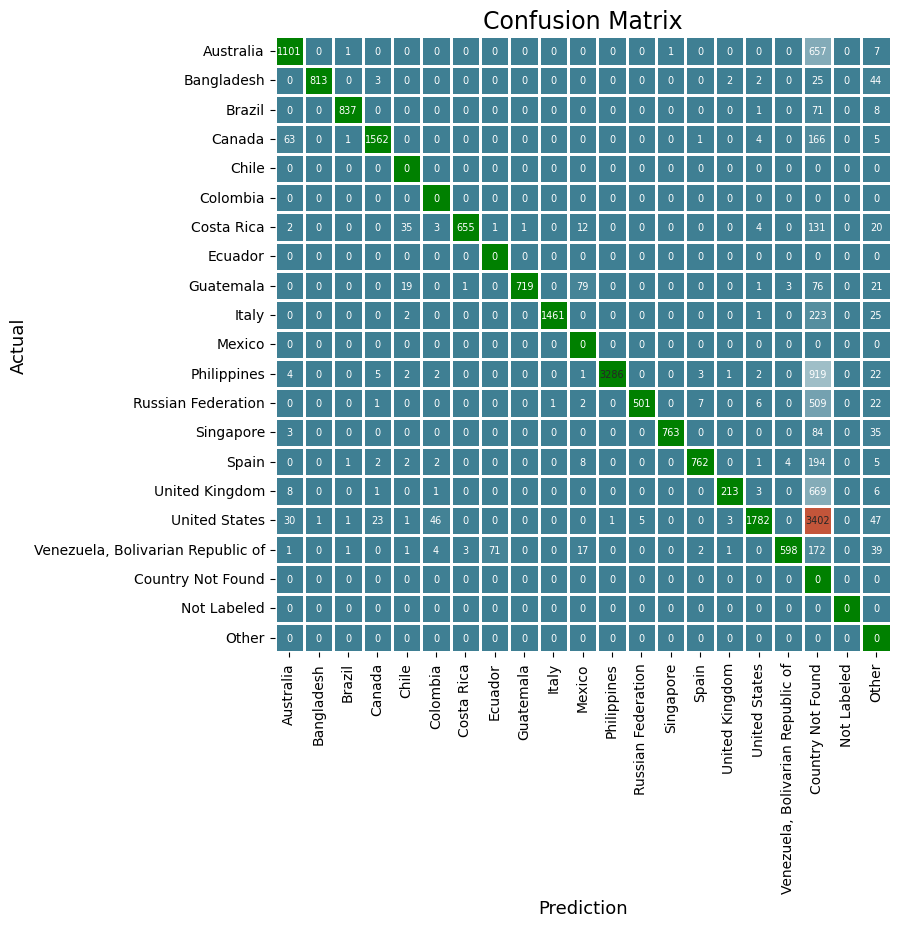

Accuracy: 0.6492559844727195
Precision: 0.9845621359268543
Recall: 0.6492559844727195
F1-score: 0.7584358069428289
Unique Predict Labels:  ['Australia', 'Bangladesh', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Country Not Found', 'Ecuador', 'Guatemala', 'Italy', 'Mexico', 'Other', 'Philippines', 'Russian Federation', 'Singapore', 'Spain', 'United Kingdom', 'United States', 'Venezuela, Bolivarian Republic of']
Unique Actual Labels:  ['Australia', 'Bangladesh', 'Brazil', 'Canada', 'Costa Rica', 'Guatemala', 'Italy', 'Philippines', 'Russian Federation', 'Singapore', 'Spain', 'United Kingdom', 'United States', 'Venezuela, Bolivarian Republic of']
Number of rows:  23185
parsed_pred_country
Country Not Found                    7298
Philippines                          3287
United States                        1807
Canada                               1597
Italy                                1462
Australia                            1212
Brazil                                842

c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

In [316]:
# CM for Country 

#remove NULL entries from the dataframe
testing_df2 = testing_df2[testing_df2['country'].notnull()]
#remove Not labeled entries from the dataframe
testing_df2 = testing_df2[testing_df2['country'] != 'Not labeled']
plt_confusion_matrix(testing_df2['country'],testing_df2['parsed_pred_country'])

In [ ]:
import inflect

# Create an instance of the inflect engine
engine = inflect.engine()

# Convert a plural word to a singular word
singular_word = engine.singular_noun('Philippines Floods')

# Print the singular word
print(singular_word)

Philippines Flood
